In [ ]:
# THE CONSUMER PRICE INDEX (CPI) IS A MEASURE OF THE AVERAGE CHANGE OVER TIME IN THE PRICES PAID BY URBAN CONSUMERS FOR A MARKET BASKET OF CONSUMER GOODS AND SERVICES.
# IN THIS CPI SERIES INDEX WE ARE LOOKING AT GASOLINE PRICES OVER THE PAST 10 YEAR PERIOD - INCREASE CPI = INFLATION = RISING COST OF LIVING
# TIME SERIES FORECASTING WITH ARIMA MODELING IS STATISTICAL AND PREDICTIVE APPROACH OF SEEING THE FUTURE BASED ON HISTORICAL DATA

In [1]:
#ALL THE PACKAGES I HAVE CAME ACROSS WHICH CAN DO MANY DIFFERET WAYS OF VIZUALIZATION IN PYTHON

import requests
import json
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# SECTION OF CODE WHERE I CONNECT TO THE BLS.GOV API FOR CPI DATA
BLS_API_KEY = 'f25896f3a6d24c739dff89912a87b169'

headers = {'Content-type': 'application/json'}
data = {
    "seriesid": ["CUUR0000SETB01"],
    "startyear": "2014",
    "endyear": "2025",
    "registrationkey": BLS_API_KEY
}


response = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', json=data, headers=headers)
json_data = response.json()

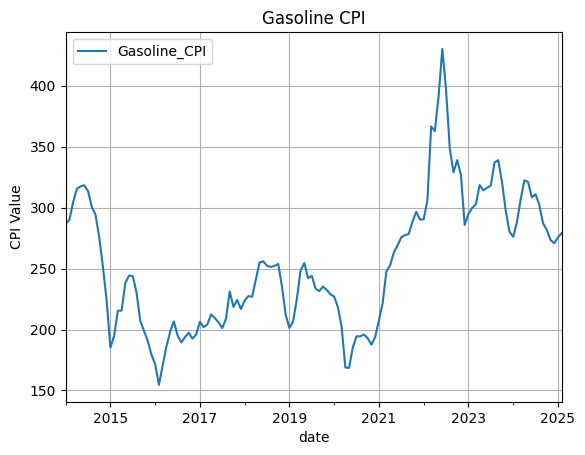

In [3]:
# THERE ARE MULTIPLE WAYS OF SAVING THE VARIOUS FIELDS FROM THE API. A SIMPLE LINE CHART OF PHARMA CPI.

series_data = json_data['Results']['series'][0]['data']
df = pd.DataFrame(series_data)
df['value'] = df['value'].astype(float)
df['date'] = pd.to_datetime(df['year'] + '-' + df['period'].str[1:] + '-01')
df = df[['date', 'value']].sort_values('date').reset_index(drop=True)
df.set_index('date', inplace=True)
df.rename(columns={'value': 'Gasoline_CPI'}, inplace=True)

# Plot
df.plot(title='Gasoline CPI')
plt.ylabel('CPI Value')
plt.grid(True)
plt.show()

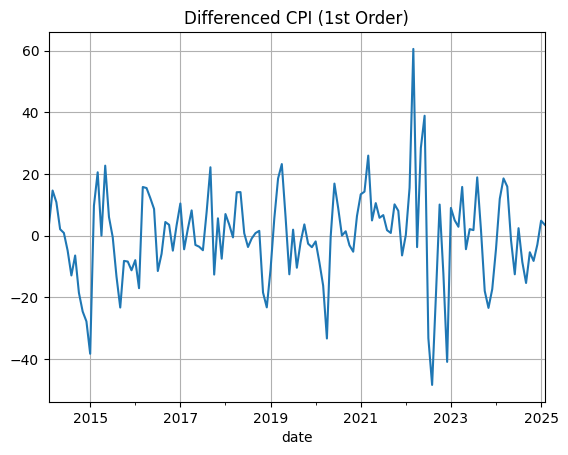

In [4]:
# THE FIRST DIFFERENCING - WHAT I AM LOOKING FOR IS A FLAT MEAN AND VARIANCE OVER TIME. NO CLEAR TRENDS OR SEASONALITY.
# No Trend: The data fluctuates around a relatively constant mean.
# Constant Variance: The ups and downs should be roughly the same size over time.
# Random Noise Appearance: It looks more like a flat, unpredictable series — no obvious patterns.
# ADF Test p-value < 0.05: Statistically confirms stationarity.
# IF FINANCIAL DATA, RULE OF THUMB IS THAT THE DATA ALWAYS NEEDS TO BE DIFFERENCED AT LEAST ONCE. CPI IS THAT.

ts = df['Gasoline_CPI']
ts_diff = ts.diff().dropna()

ts_diff.plot(title='Differenced CPI (1st Order)')
plt.grid(True)
plt.show()

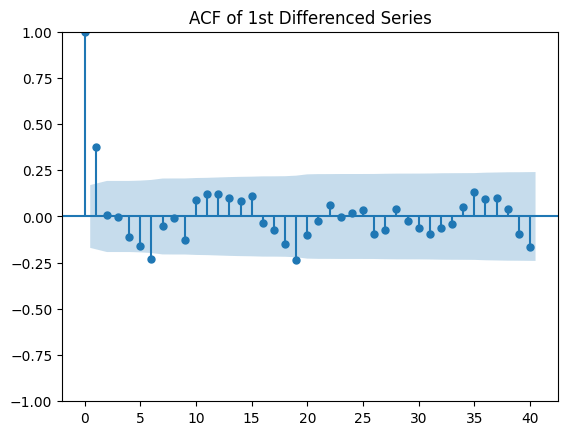

In [5]:
#ACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_acf(ts_diff, lags=40)
plt.title("ACF of 1st Differenced Series")
plt.show()

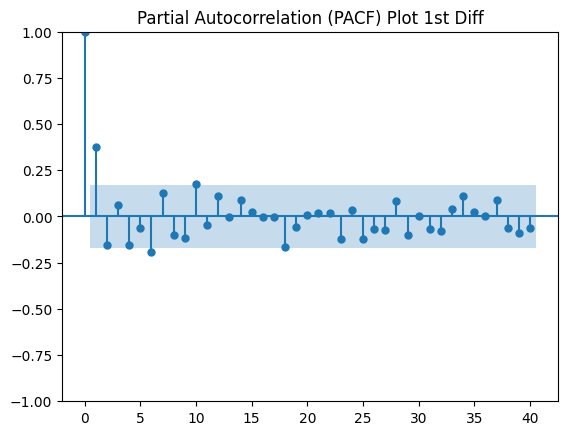

In [6]:
# PACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_pacf(ts_diff, lags=40, method='ywm')
plt.title("Partial Autocorrelation (PACF) Plot 1st Diff")
plt.show()

In [7]:
# ADF TEST OUTPUT
# P-VALUE >0.05 - FAIL TO REJECT NULL -> TIME SERIES IS NON STATIONARY
# P-VALUE <= 0.05 - REJECT NULL -> TIME SERIES IS STATIONARY

result = adfuller(ts_diff)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -3.640534266830742
p-value: 0.005031743462418232


In [8]:
model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

In [9]:
forecast_1_result = model_fit.get_forecast(steps=12)
forecast_1 = forecast_1_result.predicted_mean
conf_int = forecast_1_result.conf_int()
residuals = model_fit.resid

In [ ]:
# Ljung-Box Q Test
# A p-value greater than 0.05 (or 5%) suggests the residuals are random and independent, indicating the model is a good fit

In [10]:
# Perform Ljung-Box test (default lag is 10)
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
10  2.591403   0.989476


In [ ]:
# lb_pvalue -> P-value → the most important part
# If p-value > 0.05 → residuals do NOT show autocorrelation → model looks good!
# If p-value < 0.05 → residuals still have autocorrelation → model may be missing something.

In [11]:
ljung_box_results = acorr_ljungbox(residuals, lags=range(1, 21), return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
1   0.017555   0.894591
2   0.344290   0.841857
3   0.382603   0.943812
4   0.444382   0.978685
5   0.457572   0.993595
6   0.990116   0.985984
7   1.147552   0.992085
8   1.163587   0.996989
9   2.581239   0.978618
10  2.591403   0.989476
11  3.036370   0.990236
12  3.542208   0.990355
13  4.342862   0.986968
14  4.444013   0.992147
15  4.523806   0.995448
16  4.857618   0.996417
17  4.937260   0.997942
18  4.946583   0.998940
19  6.356753   0.996933
20  6.670571   0.997634


In [12]:
last_date = ts.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_1.index = forecast_index
conf_int.index = forecast_index

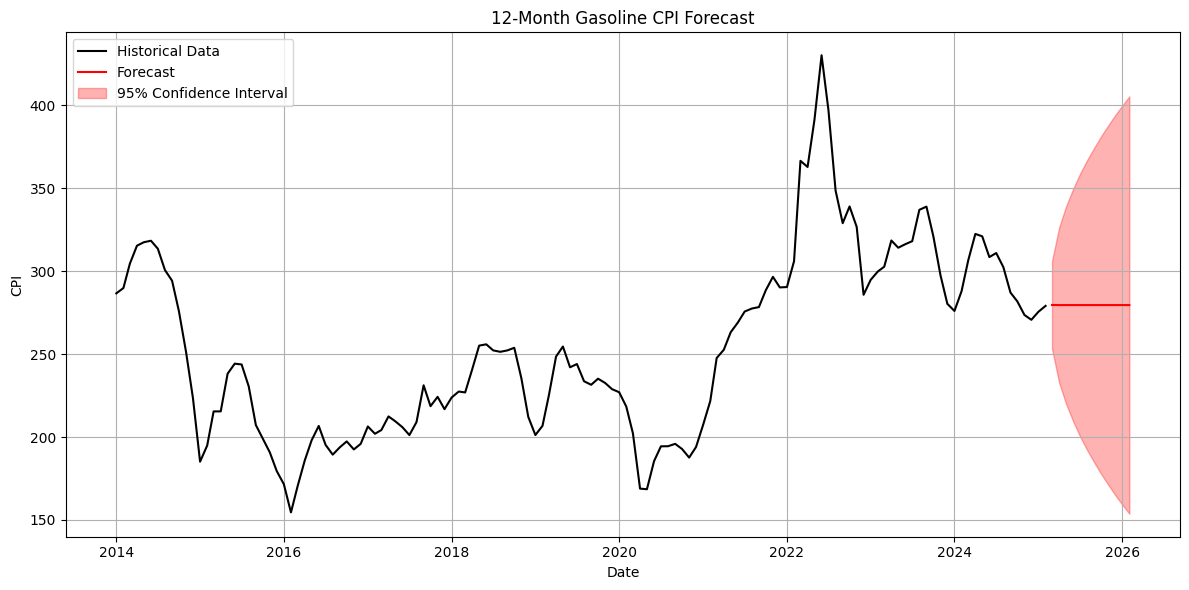

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Historical Data', color='black')
plt.plot(forecast_1, label='Forecast', color='red')
plt.fill_between(forecast_1.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('12-Month Gasoline CPI Forecast')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
print("Forecast with 1st Differencing:")
print(forecast_1)

Forecast with 1st Differencing:
2025-03-01    279.615264
2025-04-01    279.529621
2025-05-01    279.542807
2025-06-01    279.540776
2025-07-01    279.541089
2025-08-01    279.541041
2025-09-01    279.541048
2025-10-01    279.541047
2025-11-01    279.541047
2025-12-01    279.541047
2026-01-01    279.541047
2026-02-01    279.541047
Freq: MS, Name: predicted_mean, dtype: float64


In [18]:
forecast_df = pd.DataFrame({
    'Forecast': forecast_1,
    'Lower CI (95%)': conf_int.iloc[:, 0],
    'Upper CI (95%)': conf_int.iloc[:, 1]
})



In [19]:
print(forecast_df)

              Forecast  Lower CI (95%)  Upper CI (95%)
2025-03-01  279.615264      253.122181      306.108348
2025-04-01  279.529621      232.739204      326.320038
2025-05-01  279.542807      220.071273      339.014340
2025-06-01  279.540776      209.501655      349.579898
2025-07-01  279.541089      200.352483      358.729695
2025-08-01  279.541041      192.152863      366.929218
2025-09-01  279.541048      184.659677      374.422419
2025-10-01  279.541047      177.716357      381.365737
2025-11-01  279.541047      171.217188      387.864907
2025-12-01  279.541047      165.086472      393.995623
2026-01-01  279.541047      159.267853      399.814241
2026-02-01  279.541047      153.718027      405.364068


In [ ]:
# MY CONCLUSION AFTER DOING THE FIRST DIFFERENCING. EVEN THOUGH THERE IS SOME WHITE NOISE IN THE ACF PLOT THE TREND LOOKS RELATIVELY STABLE AND STATIONARY AFTER 1 DIFF

In [ ]:
# THIS MY ATTEMPT TO GET MORE CONSERVATIVE AND EXPLORE IMPACT IF I DO A DOUBLE DIFFERENCING

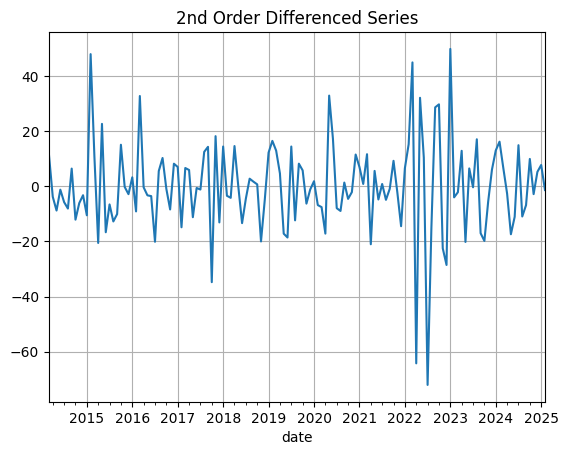

In [20]:
ts2 = df['Gasoline_CPI']
ts_diff2 = ts_diff.diff().dropna()

ts_diff2.plot(title="2nd Order Differenced Series")
plt.grid(True)
plt.show()


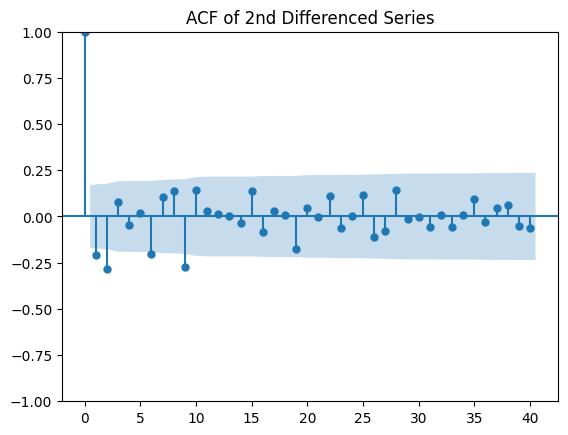

In [21]:
plot_acf(ts_diff2, lags=40)
plt.title("ACF of 2nd Differenced Series")
plt.show()

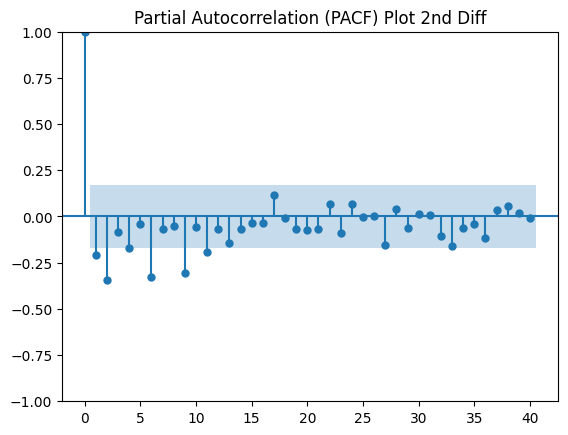

In [22]:
# PACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_pacf(ts_diff2, lags=40, method='ywm')
plt.title("Partial Autocorrelation (PACF) Plot 2nd Diff")
plt.show()

In [23]:
# ADF TEST OUTPUT
# P-VALUE >0.05 - FAIL TO REJECT NULL -> TIME SERIES IS NON STATIONARY
# P-VALUE <= 0.05 - REJECT NULL -> TIME SERIES IS STATIONARY

result = adfuller(ts_diff2)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -7.3589497934513695
p-value: 9.613368010281251e-11


In [24]:
model = ARIMA(ts2, order=(1, 1, 1))
model_fit = model.fit()

In [25]:
forecast_2_result = model_fit.get_forecast(steps=12)
forecast_2 = forecast_2_result.predicted_mean
conf_int_2 = forecast_2_result.conf_int()
residuals_2 = model_fit.resid

In [ ]:
# Ljung-Box Q Test
# A p-value greater than 0.05 (or 5%) suggests the residuals are random and independent, indicating the model is a good fit

In [26]:
# Perform Ljung-Box test (default lag is 10)
ljung_box_results = acorr_ljungbox(residuals_2, lags=[10], return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
10  2.591403   0.989476


In [ ]:
# lb_pvalue -> P-value → the most important part
# If p-value > 0.05 → residuals do NOT show autocorrelation → model looks good!
# If p-value < 0.05 → residuals still have autocorrelation → model may be missing something.

In [27]:
ljung_box_results = acorr_ljungbox(residuals_2, lags=range(1, 21), return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
1   0.017555   0.894591
2   0.344290   0.841857
3   0.382603   0.943812
4   0.444382   0.978685
5   0.457572   0.993595
6   0.990116   0.985984
7   1.147552   0.992085
8   1.163587   0.996989
9   2.581239   0.978618
10  2.591403   0.989476
11  3.036370   0.990236
12  3.542208   0.990355
13  4.342862   0.986968
14  4.444013   0.992147
15  4.523806   0.995448
16  4.857618   0.996417
17  4.937260   0.997942
18  4.946583   0.998940
19  6.356753   0.996933
20  6.670571   0.997634


In [28]:
last_date_V2 = ts2.index[-1]
forecast_index_2 = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_2.index = forecast_index_2
conf_int_2.index_2 = forecast_index_2

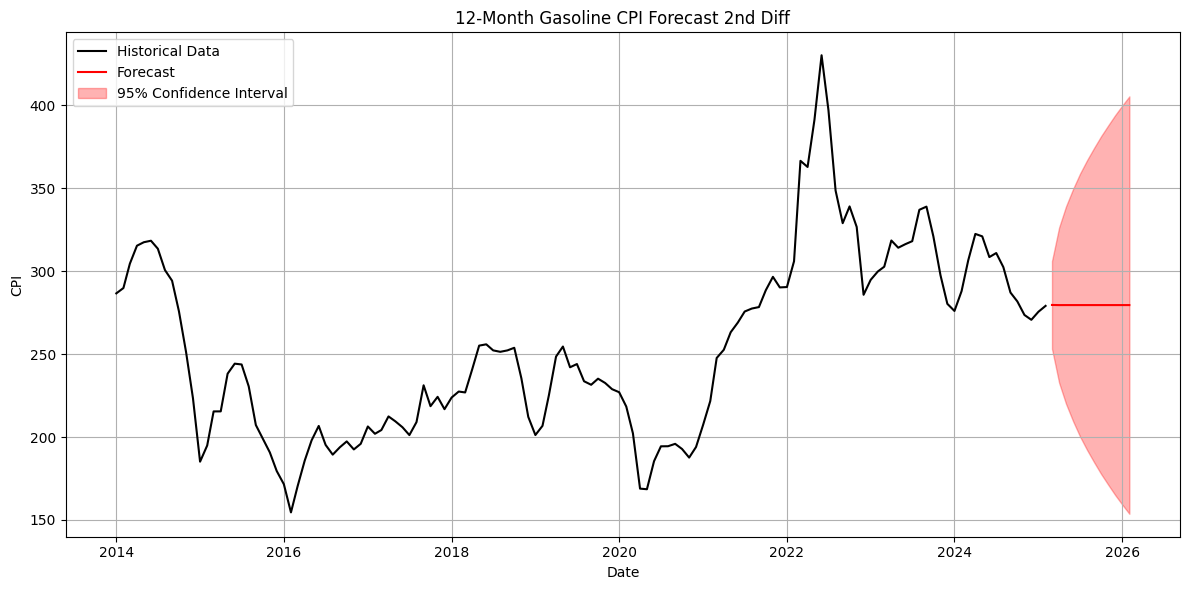

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Historical Data', color='black')
plt.plot(forecast_2, label='Forecast', color='red')
plt.fill_between(forecast_2.index, conf_int_2.iloc[:, 0], conf_int_2.iloc[:, 1],
                 color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('12-Month Gasoline CPI Forecast 2nd Diff')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
print("Forecast with 2ND Differencing:")
print(forecast_2)

Forecast with 2ND Differencing:
2025-03-01    279.615264
2025-04-01    279.529621
2025-05-01    279.542807
2025-06-01    279.540776
2025-07-01    279.541089
2025-08-01    279.541041
2025-09-01    279.541048
2025-10-01    279.541047
2025-11-01    279.541047
2025-12-01    279.541047
2026-01-01    279.541047
2026-02-01    279.541047
Freq: MS, Name: predicted_mean, dtype: float64


In [31]:
forecast_2_df = pd.DataFrame({
    'Forecast': forecast_2,
    'Lower CI (95%)': conf_int_2.iloc[:, 0],
    'Upper CI (95%)': conf_int_2.iloc[:, 1]
})

In [32]:
print(forecast_2_df)

              Forecast  Lower CI (95%)  Upper CI (95%)
2025-03-01  279.615264      253.122181      306.108348
2025-04-01  279.529621      232.739204      326.320038
2025-05-01  279.542807      220.071273      339.014340
2025-06-01  279.540776      209.501655      349.579898
2025-07-01  279.541089      200.352483      358.729695
2025-08-01  279.541041      192.152863      366.929218
2025-09-01  279.541048      184.659677      374.422419
2025-10-01  279.541047      177.716357      381.365737
2025-11-01  279.541047      171.217188      387.864907
2025-12-01  279.541047      165.086472      393.995623
2026-01-01  279.541047      159.267853      399.814241
2026-02-01  279.541047      153.718027      405.364068
